In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib
import m2cgen as m2c

# file_path = "New_Combined_MarchMadness_Data.csv"
# file_path = "all_march_madness_data.csv"
file_path = "data_sets/least_variables.csv"
# file_path = "no_rank_variable.csv"

ModuleNotFoundError: No module named 'pandas'

In [52]:
# ---------------------------------------------------------
# 1. CREATE TARGET + KEEP ROUND 64 ONLY
# ---------------------------------------------------------
df['first_round_win'] = df['ROUND'].apply(lambda x: 0 if x == 64 else 1)

X_numeric = X.select_dtypes(include='number')

df_first_round = df[df['ROUND'] == 64].copy()
df_first_round = df_first_round.dropna(subset=['first_round_win'])

y = df_first_round['first_round_win']
X = df_first_round.drop(columns=['first_round_win', 'ROUND'], errors='ignore')

cols_to_drop = [
    'CURRENT ROUND',
    'team',
    'SEED',  # drop duplicates
]

X = X.drop(columns=cols_to_drop, errors='ignore')


# ---------------------------------------------------------
# 3. TRAIN/TEST SPLIT
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=92,
    stratify=y
)

# ---------------------------------------------------------
# 4. FIT RANDOM FOREST
# ---------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=92,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
base_acc = accuracy_score(y_test, y_pred)

print("Base Accuracy (all features):", base_acc)

# ---------------------------------------------------------
# 5. FEATURE IMPORTANCE PLOT
# ---------------------------------------------------------
importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("\nTop features sorted by importance:\n")
print(feat_df)

# ---------------------------------------------------------
# 6. SEARCH BEST NUMBER OF TOP FEATURES
# ---------------------------------------------------------
best_acc = 0
best_k = None
best_features = None

sorted_features = feat_df['feature'].tolist()

for k in range(1, len(sorted_features) + 1):
    selected = sorted_features[:k]

    X_train_k = X_train[selected]
    X_test_k = X_test[selected]

    rf_k = RandomForestClassifier(
        n_estimators=500,
        random_state=92,
        class_weight='balanced'
    )
    rf_k.fit(X_train_k, y_train)
    y_pred_k = rf_k.predict(X_test_k)

    acc_k = accuracy_score(y_test, y_pred_k)

    if acc_k > best_acc:
        best_acc = acc_k
        best_k = k
        best_features = selected

print("\n===================================================")
print(f"BEST ACCURACY FOUND: {best_acc:.4f} using top {best_k} features")
print("===================================================")
print("Best feature set:")
print(best_features)

# ---------------------------------------------------------
# 7. PRINT THEIR IMPORTANCES
# ---------------------------------------------------------
best_imp_df = feat_df[feat_df['feature'].isin(best_features)]

print("\nFeature importances for BEST model:\n")
print(best_imp_df)

ValueError: could not convert string to float: 'ASun'

In [19]:
# Load data
df = pd.read_csv(file_path)

# Create first_round_win: 0 if ROUND == 64, else 1
df['first_round_win'] = df['ROUND'].apply(lambda x: 0 if x == 64 else 1)

# Keep only the first-round row (ROUND == 64) for each team/year
df_first_round = df[df['ROUND'] == 64].copy()

# Drop any missing targets
df_first_round = df_first_round.dropna(subset=['first_round_win'])

# Now target and features
y = df_first_round['first_round_win']
X = df_first_round.drop(columns=['first_round_win', 'ROUND'], errors='ignore')

# --- Create difference features for opponent stats ---
opponent_cols = [col for col in X.columns if col.startswith("Opp")]

for opp_col in opponent_cols:
    # Match the team column by removing 'Opp'
    team_col = opp_col.replace("Opp", "")
    
    if team_col in X.columns:
        diff_col = team_col + "_diff"
        X[diff_col] = X[team_col] - X[opp_col]

# Drop the original team and opponent columns to avoid redundancy
cols_to_drop = opponent_cols + [col for col in X.columns if col in [c.replace("Opp", "") for c in opponent_cols]]
X = X.drop(columns=cols_to_drop, errors='ignore')

# Add additional interaction features
X["AdjEM_AdjTempo_ratio"] = X["AdjEM"] / (X["AdjTempo"] + 1e-6)  # avoid divide by zero
X["Height_Experience_interaction"] = X["AvgHeight"] * X["Experience"]
X["Seed_AdjEM_interaction"] = X["SEED"] * X["AdjEM"]

print("Features used by the model:", X.columns.tolist())

Features used by the model: ['year', 'Short Conference Name', 'Adjusted Temo', 'Adjusted Tempo Rank', 'Raw Tempo', 'Raw Tempo Rank', 'Adjusted Offensive Efficiency', 'Adjusted Offensive Efficiency Rank', 'Raw Offensive Efficiency', 'Raw Offensive Efficiency Rank', 'Adjusted Defensive Efficiency', 'Adjusted Defensive Efficiency Rank', 'Raw Defensive Efficiency', 'Raw Defensive Efficiency Rank', 'Avg Possession Length (Offense)', 'Avg Possession Length (Offense) Rank', 'Avg Possession Length (Defense)', 'Avg Possession Length (Defense) Rank', 'eFGPct', 'RankeFGPct', 'TOPct', 'RankTOPct', 'ORPct', 'RankORPct', 'FTRate', 'RankFTRate', 'OffFT', 'RankOffFT', 'Off2PtFG', 'RankOff2PtFG', 'Off3PtFG', 'RankOff3PtFG', 'DefFT', 'RankDefFT', 'Def2PtFG', 'RankDef2PtFG', 'Def3PtFG', 'RankDef3PtFG', 'Tempo', 'RankTempo', 'AdjTempo', 'RankAdjTempo', 'OE', 'RankOE', 'AdjOE', 'RankAdjOE', 'DE', 'RankDE', 'AdjDE', 'RankAdjDE', 'AdjEM', 'RankAdjEM', 'RankFG2Pct', 'RankFG3Pct', 'RankFTPct', 'RankBlockPct', 

In [28]:
# TEST AND TRAIN
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,          
    y,          
    test_size=0.3,   
    random_state=92, 
    stratify=y      
)
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (379, 145) (379,)
Testing set: (163, 145) (163,)


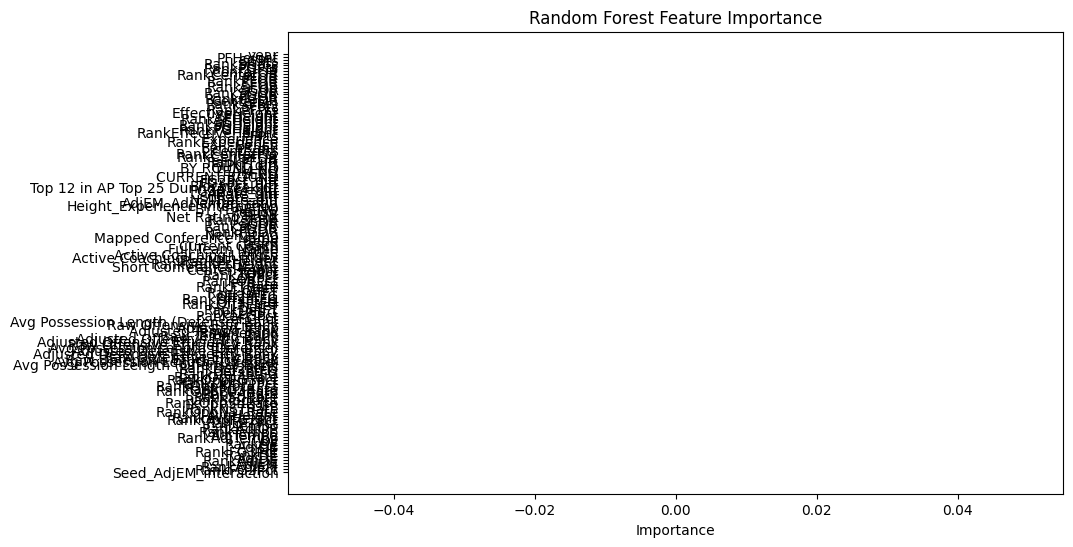

In [34]:
# --- Train Random Forest without hyperparameter tuning ---
        
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # optional
)

# Fit the model
rf_base.fit(X_train, y_train)

# Make predictions
y_pred = rf_base.predict(X_test)

importances = rf_base.feature_importances_
feat_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()



In [22]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=92
)
rf.fit(X_train, y_train)

# ------------------------------------------------------
# 4. FEATURE IMPORTANCE PLOT
# ------------------------------------------------------
importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# ------------------------------------------------------
# 5. LOOP: TEST ACCURACY USING TOP k FEATURES
# ------------------------------------------------------
accuracies = []

for k in range(1, len(feat_df)+1):
    top_k_features = feat_df['feature'].iloc[:k]
    
    # Train RF using only top k variables
    rf_k = RandomForestClassifier(
        n_estimators=500,
        random_state=92
    )
    rf_k.fit(X_train[top_k_features], y_train)

    y_pred_k = rf_k.predict(X_test[top_k_features])
    acc_k = accuracy_score(y_test, y_pred_k)
    
    accuracies.append((k, acc_k))

# Find best number of variables
best_k, best_acc = max(accuracies, key=lambda x: x[1])

print("\n-------------------------------")
print(f"Best accuracy achieved with k = {best_k} variables")
print(f"Accuracy: {best_acc:.4f}")
print("-------------------------------\n")

# ------------------------------------------------------
# 6. PRINT BEST FEATURES + IMPORTANCE VALUES
# ------------------------------------------------------
best_features = feat_df.iloc[:best_k]
print("Top features producing highest accuracy:\n")
print(best_features)


ValueError: could not convert string to float: 'ASun'

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Train Random Forest without hyperparameter tuning ---
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # optional
)

# Fit the model
rf_base.fit(X_train, y_train)

# Make predictions
y_pred = rf_base.predict(X_test)

# --- Evaluate ---
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Feature Importance ---
importances = rf_base.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.ylabel("Importance")
plt.show()

ValueError: could not convert string to float: 'ASun'

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Step 1: Determine feature ranking ---
importances = rf_base.feature_importances_
indices = np.argsort(importances)[::-1]  # descending order
features = X_train.columns

# --- Step 2: Track best accuracy for subsets (your existing loop) ---
best_acc = 0
best_n = 0
best_features = []
accuracy_results = []

rf_params = {
    'random_state': 42,
    'class_weight': 'balanced',
}

for n in range(1, len(features) + 1):
    top_features = features[indices[:n]]
    
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train[top_features], y_train)
    
    y_pred = rf_model.predict(X_test[top_features])
    acc = accuracy_score(y_test, y_pred)
    accuracy_results.append((n, acc))
    
    print(f"Top {n} features → Accuracy = {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_n = n
        best_features = top_features

print("\n=== Best Result ===")
print(f"Number of top features: {best_n}")
print(f"Features: {list(best_features)}")
print(f"Highest accuracy: {best_acc:.4f}")

# --- Step 3: Build final model using top 7 features ---
top_7_features = features[indices[:7]]
final_model = RandomForestClassifier(**rf_params)
final_model.fit(X_train[top_7_features], y_train)

# --- Step 4: Evaluate final model ---
y_pred_final = final_model.predict(X_test[top_7_features])
print("\n=== Final Model Evaluation (Top 7 Features) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")

NameError: name 'best_rf' is not defined

In [51]:
# Export the trained RF to JS code
js_code = m2c.export_to_javascript(final_model)

# Save it to a JS file
with open("model.js", "w") as f:
    f.write(js_code)

In [66]:
year_to_test = 2024
X_year = X[df['year'] == year_to_test]
y_year = y[df['year'] == year_to_test]

# Select top 7 features
X_year_top7 = X_year[top_7_features]

# Predict
y_pred_year = final_model.predict(X_year_top7)
y_prob_year = final_model.predict_proba(X_year_top7)  # optional: probabilities

# Create a results DataFrame
results_year = X_year_top7.copy()
results_year['Actual'] = y_year
results_year['Predicted'] = y_pred_year
results_year['Prob_A'] = y_prob_year[:,0]   # probability team A wins
results_year['Prob_B'] = y_prob_year[:,1]   # probability team B wins

# Print the results
print(results_year)


      AdjEM_AdjTempo_ratio     AdjEM  SEED  Seed_AdjEM_interaction  \
4                 0.563584  36.42620   1.0                36.42620   
24                0.491000  31.17300   1.0                31.17300   
31                0.457092  30.61750   1.0                30.61750   
60                0.400030  27.98960   4.0               111.95840   
94                0.384088  26.61470   2.0                53.22940   
...                    ...       ...   ...                     ...   
1105             -0.067837  -4.50865  16.0               -72.13840   
1106             -0.067498  -4.65409   NaN                     NaN   
1120             -0.109413  -7.09337  16.0              -113.49392   
1125             -0.123638  -8.38320   NaN                     NaN   
1129             -0.162422  -9.99734  16.0              -159.95744   

      FG2Pct_diff      ORPct      TOPct  Actual  Predicted  Prob_A  Prob_B  
4       15.944702  36.697966  14.499681       1          1    0.01    0.99  
24   

In [48]:
df_tourney = df[(df['year'] == 2019) & (df['ROUND'] < 64)]
print(df_tourney)

year_to_test = 2019
X_year = X[df['year'] == year_to_test]
y_year = y[df['year'] == year_to_test]

# --- Select top 7 features ---
X_year_top7 = X_year[top_7_features]

# --- Predict ---
y_pred_year = final_model.predict(X_year_top7)
y_prob_year = final_model.predict_proba(X_year_top7)  # gives probabilities for each class

# --- Evaluate ---
from sklearn.metrics import accuracy_score, confusion_matrix

print(f"\n=== Final Model Evaluation on {year_to_test} ===")
print(f"Accuracy: {accuracy_score(y_year, y_pred_year):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_year, y_pred_year))

# --- Optional: Inspect individual predictions ---
results_year = X_year_top7.copy()
results_year['Actual'] = y_year
results_year['Predicted'] = y_pred_year
results_year['Prob_A'] = y_prob_year[:,0]
results_year['Prob_B'] = y_prob_year[:,1]

print(results_year)

     year Short Conference Name  Adjusted Temo  Adjusted Tempo Rank  \
8    2019                   ACC           59.4                  353   
15   2019                   WCC           70.2                   62   
28   2019                   B10           66.9                  211   
29   2019                   ACC           72.1                   20   
38   2019                   B12           66.6                  231   
58   2019                   B10           64.8                  317   
69   2019                   ACC           74.3                    6   
75   2019                   SEC           65.6                  284   
87   2019                   B10           65.9                  268   
102  2019                   SEC           67.8                  164   
134  2019                   SEC           67.9                  155   
166  2019                  Amer           66.1                  260   
168  2019                   ACC           63.7                  334   
238  2

/var/folders/wg/nqrq3myn1wg6xmlstd5sxz180000gp/T/ipykernel_95629/3041143795.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_year = X[df['year'] == year_to_test]


NameError: name 'top_7_features' is not defined

In [50]:
print(top_features)
print(X_train.columns.tolist())

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Define base Random Forest ---
# Holding number of estimators fixed
rf_base = RandomForestClassifier(
    n_estimators=100,          # <-- held constant
    random_state=42,
    class_weight='balanced'
)

# --- Define hyperparameter grid ---
# Explore depth from 2 to 30 (step = 2)
param_grid = {
    'max_depth': list(range(2, 32, 2)),
    'min_samples_split': [60],
    'min_samples_leaf': [7]
}

# --- Grid Search ---
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# --- Use only top features ---
top_features = [
    'AdjEM_AdjTempo_ratio', 'AdjEM', 'SEED',
    'Seed_AdjEM_interaction', 'FG2Pct_diff', 'ORPct', 'TOPct'
]

grid_search.fit(X_train[top_features], y_train)

# --- Best model ---
best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

['AdjEM_AdjTempo_ratio', 'AdjEM', 'SEED', 'Seed_AdjEM_interaction', 'FG2Pct_diff', 'ORPct', 'TOPct']
['year', 'Short Conference Name', 'Adjusted Temo', 'Adjusted Tempo Rank', 'Raw Tempo', 'Raw Tempo Rank', 'Adjusted Offensive Efficiency', 'Adjusted Offensive Efficiency Rank', 'Raw Offensive Efficiency', 'Raw Offensive Efficiency Rank', 'Adjusted Defensive Efficiency', 'Adjusted Defensive Efficiency Rank', 'Raw Defensive Efficiency', 'Raw Defensive Efficiency Rank', 'Avg Possession Length (Offense)', 'Avg Possession Length (Offense) Rank', 'Avg Possession Length (Defense)', 'Avg Possession Length (Defense) Rank', 'eFGPct', 'RankeFGPct', 'TOPct', 'RankTOPct', 'ORPct', 'RankORPct', 'FTRate', 'RankFTRate', 'OffFT', 'RankOffFT', 'Off2PtFG', 'RankOff2PtFG', 'Off3PtFG', 'RankOff3PtFG', 'DefFT', 'RankDefFT', 'Def2PtFG', 'RankDef2PtFG', 'Def3PtFG', 'RankDef3PtFG', 'Tempo', 'RankTempo', 'AdjTempo', 'RankAdjTempo', 'OE', 'RankOE', 'AdjOE', 'RankAdjOE', 'DE', 'RankDE', 'AdjDE', 'RankAdjDE', 'AdjEM

KeyError: "['AdjEM_AdjTempo_ratio', 'SEED', 'Seed_AdjEM_interaction', 'FG2Pct_diff'] not in index"

In [50]:
p_obs = 86.76 / 100

# Hypothesized proportion
p0 = 78.125 / 100

# Sample size
n = 100  # replace with your actual sample size

# Number of "successes" in the sample
count = int(p_obs * n)

# Perform one-proportion z-test
stat, pval = proportions_ztest(count, n, value=p0)
print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {pval:.4f}")

Z-statistic: 1.7292
P-value: 0.0838


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Define base Random Forest ---
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

# --- Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    'min_samples_split': [60],
    'min_samples_leaf': [7]
}

# # --- Run Grid Search with 3-fold cross-validation ---
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Use only top features
top_features = ['AdjEM_AdjTempo_ratio', 'AdjEM', 'SEED', 
                'Seed_AdjEM_interaction', 'FG2Pct_diff', 'ORPct', 'TOPct']

grid_search.fit(X_train[top_features], y_train)

# --- Best model ---
best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# --- Evaluate on test set ---
y_pred = best_rf.predict(X_test[top_features])
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Feature Importance ---
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Tuned Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [top_features[i] for i in indices], rotation=45)
plt.ylabel("Importance")
plt.show()

# --- Visualize accuracy as a function of certain hyperparameters ---
# Example: n_estimators vs mean CV accuracy
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
n_estimators_list = param_grid['min_samples_leaf']

# Aggregate scores by n_estimators
avg_scores = []
for n in n_estimators_list:
    idx = [i for i, params in enumerate(results['params']) if params['min_samples_leaf'] == n]
    avg_scores.append(np.mean(mean_test_scores[idx]))

plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, avg_scores, marker='o')
plt.title("Mean CV Accuracy vs min_samples_leaf")
plt.xlabel("param_min_samples_leaf")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

KeyError: "['AdjEM_AdjTempo_ratio', 'SEED', 'Seed_AdjEM_interaction', 'FG2Pct_diff'] not in index"

In [44]:
results = pd.DataFrame(grid_search.cv_results_)

# Function to plot accuracy vs parameter
def plot_param_vs_accuracy(param_name):
    param_values = results[param_name]
    mean_scores = results['mean_test_score']
    
    # For discrete parameters, aggregate by value
    if param_values.dtype == object or len(np.unique(param_values)) < 10:
        agg_scores = results.groupby(param_name)['mean_test_score'].mean()
        plt.figure(figsize=(8,5))
        plt.plot(agg_scores.index, agg_scores.values, marker='o')
    else:
        plt.figure(figsize=(8,5))
        plt.scatter(param_values, mean_scores)
    
    plt.title(f"Mean CV Accuracy vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Mean CV Accuracy")
    plt.grid(True)
    plt.show()

# Plot for each hyperparameter
for param in ['param_n_estimators', 'param_max_depth', 
              'param_min_samples_split', 'param_min_samples_leaf']:
    plot_param_vs_accuracy(param)

NameError: name 'grid_search' is not defined

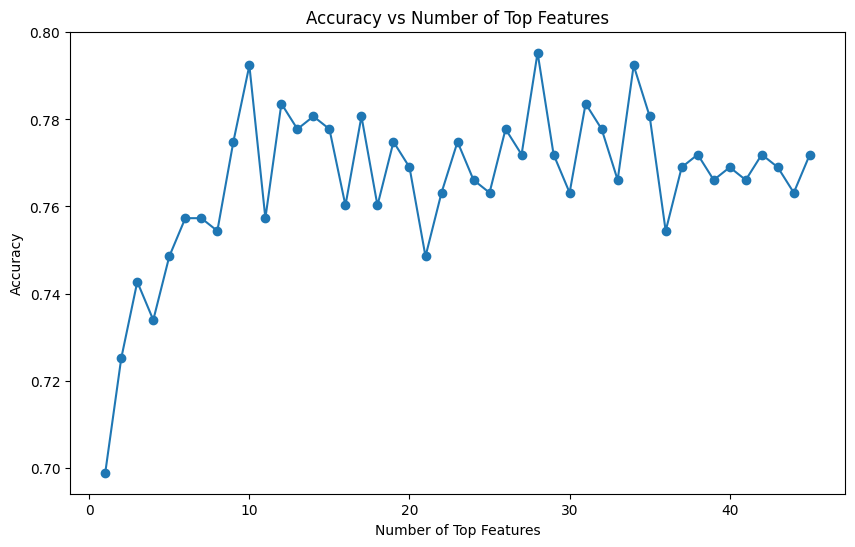

In [31]:
n_features, accs = zip(*accuracy_results)
plt.figure(figsize=(10,6))
plt.plot(n_features, accs, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Top Features")
plt.show()

In [123]:
n_correct = int(best_acc * len(y_test))  # number of correct predictions
n_total = len(y_test)                    # total predictions
p_null = .75                            # null hypothesis (random guessing)
stat, p_value = proportions_ztest(count=n_correct, nobs=n_total, value=p_null, alternative='larger')
print(f"\nProportion test against 0.5:")
print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")


Proportion test against 0.5:
Z-statistic: 2.2233
P-value: 0.0131


In [15]:
# Predict first-round winner based on seed
# Assuming smaller seed number = stronger team
y_pred_seed = (X_test['SEED'] <= 8).astype(int)  # Example: seeds 1-8 are predicted to win

# If your target is 1 = team won first round, adjust logic accordingly:
# For a more general approach, predict the higher seed in each matchup:
y_pred_seed = (X_test['SEED'] <= X_test['SEED'].median()).astype(int)

# Compute accuracy of seed-based prediction
baseline_acc = accuracy_score(y_test, y_pred_seed)
print(f"Seed-based baseline accuracy: {baseline_acc:.4f}")

Seed-based baseline accuracy: 0.7164


In [32]:
n_correct = int(best_acc * len(y_test))  # number of correct predictions
n_total = len(y_test)                    # total predictions
p_null = 0.78125                            # null hypothesis using just seed

stat, p_value = proportions_ztest(count=n_correct, nobs=n_total, value=p_null, alternative='larger')
print(f"\nProportion test against 0.5:")
print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")


Proportion test against 0.5:
Z-statistic: 0.6450
P-value: 0.2595


In [57]:
df['predicted'] = final_model.predict(X[best_features])
df['correct'] = df['predicted'] == df['first_round_win']
wrong_cases = df[df['correct'] == False]
print(wrong_cases.head())
print(f"Total wrong: {len(wrong_cases)} out of {len(df)}")
from sklearn.metrics import confusion_matrix

print(confusion_matrix(df['first_round_win'], df['predicted']))

year_to_check = 2019

# Filter for that year
df_year = df[df['year'] == year_to_check]

# Find wrong predictions in that year
wrong_year = df_year[df_year['predicted'] != df_year['first_round_win']]

# Show the first few wrong cases
print(wrong_year.head())

# Total wrong in that year
print(f"Total wrong in {year_to_check}: {len(wrong_year)} out of {len(df_year)}")

     year Short Conference Name  Avg Possession Length (Offense)  \
62   2016                   B10                             17.0   
198  2025                   ACC                             17.7   
199  2023                   B10                             19.2   
212  2025                   B12                             16.6   
224  2013                   B10                             20.9   

     Avg Possession Length (Defense)     eFGPct      TOPct      ORPct  \
62                              18.6  56.280100  17.582200  37.065970   
198                             19.1  53.379722  15.840971  33.744493   
199                             18.1  51.833678  17.210883  38.358608   
212                             18.0  53.057812  16.897767  30.501274   
224                             18.0  48.596900  15.688700  32.582500   

        FTRate      OffFT   Off2PtFG  ...   PGDR  \
62   29.980750  16.254900  49.266000  ...   9.55   
198  28.330020  16.937355  49.651972  ...  12.48